<a href="https://colab.research.google.com/github/AndreaCedenoR/Regresion-no-lineal-usando-redes-recurrentes/blob/main/IAAA_P2_Gonzalez_Cede%C3%B1o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión no lineal usando redes recurrentes

## 🧠 ¿Qué es "Regresión no lineal usando redes recurrentes"?
## 🔷 Regresión no lineal
Es un tipo de modelo que **predice valores continuos** (como precios, temperatura, niveles, etc.) pero donde la **relación entre las variables no es lineal** (es decir, no se puede trazar como una línea recta). Puede ser curva, caótica, irregular, etc.

## 🔷 Redes neuronales recurrentes (RNN)
Son redes diseñadas especialmente para trabajar con **datos secuenciales** o dependientes del tiempo. Por ejemplo: series temporales, lenguaje natural, etc.

A diferencia de las redes normales, las RNN **tienen memoria**, porque usan como entrada no solo el dato actual, sino también el resultado anterior. Esto les permite entender patrones con dependencia temporal.

## 🎯 ¿Cuál es el objetivo del proyecto?
**Predecir un valor numérico futuro** usando los valores pasados de una serie. En este caso, con una red neuronal recurrente, se busca que el modelo aprenda la dinámica del sistema (que puede ser no lineal) para hacer predicciones lo más precisas posibles.



### ✅ **Punto I:** Cargar y graficar el conjunto de datos “Data numérica”



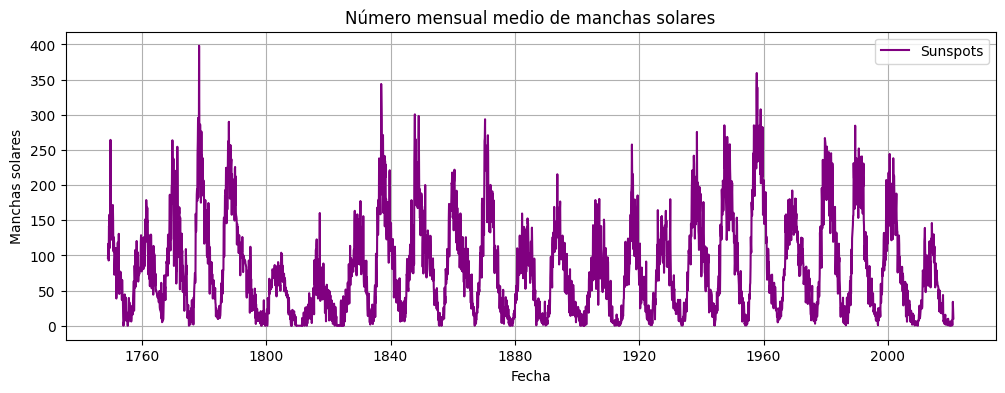

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('data_numerica.csv')

# Eliminar columna innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Asegurarse de que la fecha esté en formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Renombrar la columna de valores para facilitar
df.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)

# Convertimos la columna de Sunspots a numérico por si hay errores
df['Sunspots'] = pd.to_numeric(df['Sunspots'], errors='coerce')

# Eliminar filas con datos faltantes, si hay
df.dropna(inplace=True)

# Graficar correctamente con fechas en el eje X
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Sunspots'], label='Sunspots', color='purple')
plt.title('Número mensual medio de manchas solares')
plt.xlabel('Fecha')
plt.ylabel('Manchas solares')
plt.grid(True)
plt.legend()
plt.show()


Este bloque de código comienza importando las librerías necesarias (pandas para manejo de datos y matplotlib para visualización). Luego, carga el archivo data_numerica.csv, que contiene datos históricos del número mensual medio de manchas solares. Se realiza una limpieza básica del conjunto de datos: se elimina una columna innecesaria (Unnamed: 0), se convierte la columna Date al formato de fecha adecuado y se renombra la columna principal a Sunspots para facilitar su uso. Además, se asegura que los valores numéricos sean válidos y se eliminan posibles filas con datos faltantes. Finalmente, se genera una gráfica de línea que muestra cómo han variado las manchas solares a lo largo del tiempo, utilizando color púrpura para resaltar la serie temporal.



### ✅ **Punto II:** Dividir la data en entrenamiento y validación (20% para validación)

A continuación, dividiremos los datos de la columna Sunspots en dos partes:

**80%** de los datos se utilizarán para entrenamiento.

**20%** se reservarán para validación del modelo.

Además, como trabajaremos con una red neuronal recurrente, necesitamos convertir esta serie en secuencias (por ejemplo, usar los últimos n valores para predecir el siguiente).

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convertimos la serie de manchas solares a un array numpy
data = df['Sunspots'].values

# Escogemos una longitud de ventana (número de pasos anteriores para predecir el siguiente)
window_size = 10

# Función para generar las secuencias
def create_sequences(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

# Crear secuencias
X, y = create_sequences(data, window_size)

# Dividir en entrenamiento y validación (80% - 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Mostrar tamaños
print(f"Train: {X_train.shape}, Validation: {X_val.shape}")


Train: (2604, 10), Validation: (651, 10)


Este código transforma la serie en datos de entrada y etiquetas para entrenar un modelo secuencial, y luego hace la división sin mezclar el orden temporal, como se requiere en series de tiempo.

### ✅ **Punto 3(a)**: Red neuronal recurrente simple (RNN) con Keras

Vamos a construir y entrenar una red RNN básica para predecir el número de manchas solares usando los últimos 10 valores.

📌 **Paso 1:** Preparar los datos para Keras
Las RNN de Keras esperan datos con esta forma:
(n_muestras, pasos_temporales, características)
Como estamos usando series univariadas (solo una variable: "Sunspots"), tenemos que reestructurar X_train y X_val:

In [ ]:
# Reestructurar para que Keras entienda que es una secuencia temporal
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


📌 **Paso 2:** Crear y compilar el modelo RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Definir el modelo
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

# Compilar
model_rnn.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model_rnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

📌 **Paso 3:** Entrenar la red

In [ ]:
# Entrenar el modelo
history_rnn = model_rnn.fit(
    X_train_rnn, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val_rnn, y_val)
)


Epoch 1/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10896.0254 - val_loss: 11313.5596
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9174.3164 - val_loss: 10433.3184
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8689.1016 - val_loss: 9843.2646
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8684.1416 - val_loss: 9307.6709
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8034.8672 - val_loss: 8808.4736
Epoch 6/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7296.9697 - val_loss: 8341.1416
Epoch 7/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7332.3862 - val_loss: 7896.3428
Epoch 8/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6842.1499 - val_loss: 7484.4648
Epoch 9/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6406.9517 - val_loss: 7092.5586
Epoch 10/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6146.3257 - val_loss: 6724.5522
Epoch 11/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5903.8486 - val_loss: 6382

📈 **Paso 4:** Visualizar el error de entrenamiento

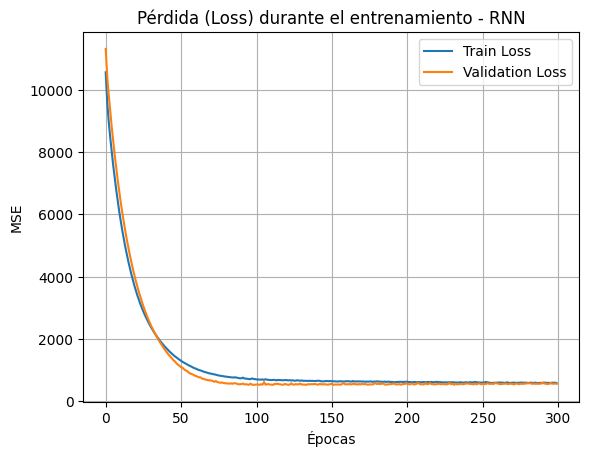

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Pérdida (Loss) durante el entrenamiento - RNN')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


### ✅ **Punto 3(b):** Red neuronal recurrente con neuronas LSTM de Keras
El objetivo aquí es usar una arquitectura LSTM (Long Short-Term Memory), que es una mejora de las RNN simples, especialmente útil para capturar dependencias de largo plazo en series temporales como la de manchas solares.

📌 **Paso 1:** Preparar los datos

Ya preparamos X_train_rnn y X_val_rnn con la forma (muestras, pasos_temporales, características), así que reusamos esos arrays.

**📌 Paso 2:** Crear y compilar el modelo LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

# Definir el modelo LSTM
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

# Compilar
model_lstm.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

**📌 Paso 3:** Entrenar el modelo



In [ ]:
# Entrenar el modelo LSTM
history_lstm = model_lstm.fit(
    X_train_rnn, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val_rnn, y_val)
)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 10826.4395 - val_loss: 10912.7676
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9160.0518 - val_loss: 9850.5107
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8270.5928 - val_loss: 9269.3447
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8080.1421 - val_loss: 8765.5684
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7622.9600 - val_loss: 8310.2754
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6784.8887 - val_loss: 7803.6782
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6846.9175 - val_loss: 7390.2681
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6422.5435 - val_loss: 7012.7598
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5942.8110 - val_loss: 6662.9155
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6000.9463 - val_loss: 6335.6426
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5550.3994 - val_loss: 6027.7915
Epo

**📈 Paso 4:** Visualizar la pérdida

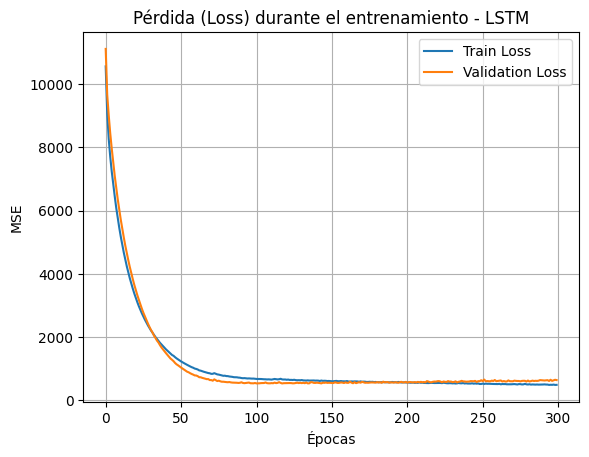

In [ ]:
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Pérdida (Loss) durante el entrenamiento - LSTM')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


### ✅ **Punto 4:** Predicción y comparación visual de RNN vs LSTM

📌 **Paso 1:** Realizar predicciones

In [ ]:
# Predicciones
y_pred_rnn = model_rnn.predict(X_val_rnn)
y_pred_lstm = model_lstm.predict(X_val_rnn)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


📌 **Paso 2:** Visualizar comparaciones

Vamos a graficar los valores reales del conjunto de validación frente a las predicciones de cada modelo:

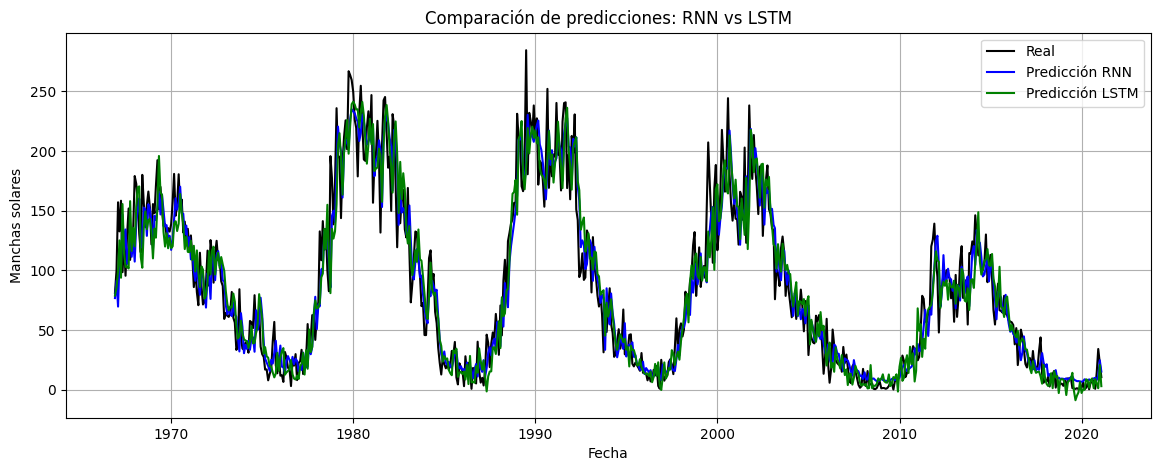

In [ ]:
# Crear rango de fechas para el eje X (solo los datos de validación)
val_dates = df['Date'].values[-len(y_val):]

plt.figure(figsize=(14, 5))

# Gráfico de comparación
plt.plot(val_dates, y_val, label='Real', color='black')
plt.plot(val_dates, y_pred_rnn.flatten(), label='Predicción RNN', color='blue')
plt.plot(val_dates, y_pred_lstm.flatten(), label='Predicción LSTM', color='green')

plt.title('Comparación de predicciones: RNN vs LSTM')
plt.xlabel('Fecha')
plt.ylabel('Manchas solares')
plt.legend()
plt.grid(True)
plt.show()


### ✅ **Punto 5:** Análisis de resultados y comparación de rendimiento
Ahora que ya se generaron las predicciones con ambos modelos (RNN y LSTM), vamos a comparar su desempeño cuantitativamente usando una métrica común de regresión: Error Cuadrático Medio (MSE).

In [ ]:
from sklearn.metrics import mean_squared_error

# Cálculo del error cuadrático medio
mse_rnn = mean_squared_error(y_val, y_pred_rnn)
mse_lstm = mean_squared_error(y_val, y_pred_lstm)

print(f"MSE - RNN: {mse_rnn:.4f}")
print(f"MSE - LSTM: {mse_lstm:.4f}")


MSE - RNN: 4106.0403
MSE - LSTM: 3936.6657
